In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# 1D Corridor

In [2]:
class LinearEnv:
    """
    Allowed states are:
    State id: [ 0 ... 10 ... 20 ]
    Type:     [ T ...  S ...  T ]
    Reward:   [-1  0   0  0   1 ]
    """
    def __init__(self):
        size = 19
        self._max_left = 1      # last non-terminal state to the left
        self._max_right = size  # last non-terminal state to the right
        self._start_state = (size // 2) + 1
        self.reset()

    def reset(self):
        self._state = self._start_state
        self._done = False
        return self._state

    def step(self, action):
        if self._done: return (self._state, 0, True)  # We are done
        if action not in [0, 1]: raise ValueError('Invalid action')

        self._state += -1 if action==0 else 1
        obs = self._state
        if self._state > self._max_right:
            reward = +1
            self._done = True
        elif self._state < self._max_left:
            reward = -1
            self._done = True
        else:
            reward = 0
            self._done = False
        return (obs, reward, self._done)

In [3]:
GROUND_TRUTH = np.arange(-20, 22, 2) / 20.0
GROUND_TRUTH[0] = GROUND_TRUTH[-1] = 0
GROUND_TRUTH

array([ 0. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  0. ])

In [4]:
env = LinearEnv()
obs_shape = [21]

pi_skewed = np.tile([0.48, 0.52], [21, 1])  # our behavioural policy
pi_random = np.tile([0.50, 0.50], [21, 1])  # target random policy
pi_greedy = np.tile([0.00, 1.00], [21, 1])  # target greedy policy

# Helper Functions

In [5]:
def generate_episode(policy):
    """Generate one complete episode"""
    trajectory = []
    done = True
    while True:
        # === time step starts ===
        if done:
            obs, reward, done = env.reset(), None, False
        else:
            obs, reward, done = env.step(action)   
        action = np.random.choice([0, 1], p=policy[obs])
        trajectory.append((obs, reward, done, action))
        if done:
            break
        # === time step ends here ===
    return trajectory

In [6]:
def plot_experiments(title, histories):
    fig = plt.figure(figsize=[18,6])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(GROUND_TRUTH[1:-1], color='gray')
    for hist in histories:
        
        Q_vals = hist[-1]
        V_vals = np.sum(pi_random*hist, axis=-1)  # backup Q into V
        E_vals = np.sum((GROUND_TRUTH - V_vals)**2, axis=-1)
        
        ax1.plot(Q_vals[1:-1,0], color='red', alpha=0.4)   # Q left
        ax1.plot(Q_vals[1:-1,1], color='green', alpha=0.4) # Q right
        ax2.plot(E_vals, color='blue', alpha=0.4)

    ax1.grid()
    ax1.set_title('Estimated State-Values')
    ax2.grid()
    ax2.set_title('Ground Truth Error')
    fig.suptitle(title, fontsize=32)
    
    plt.show()

# Incremental Monte-Carlo

Estabilish reference data

In [7]:
def mc_experiment(N, policy):
    hist = []
    C = np.zeros(obs_shape)   # count state visits (see note #1)
    V = np.zeros(obs_shape)   # state-values
    C = np.zeros(shape=[*obs_shape, 2])
    Q = np.zeros(shape=[*obs_shape, 2])

    for ep in range(N):
        trajectory = generate_episode(policy)
        for St, _, _, At in trajectory[:-1]:  # never evaluate terminal states (see note #2)
            Gt = trajectory[-1][1]  # shortcut (see note #3)
            C[St] += 1
            # V[St] = V[St] + (1/C[St]) * (Gt - V[St])
            Q[St, At] = Q[St, At] + (1/C[St, At]) * (Gt - Q[St, At])
            
        hist.append(Q.copy())
    return np.array(hist)

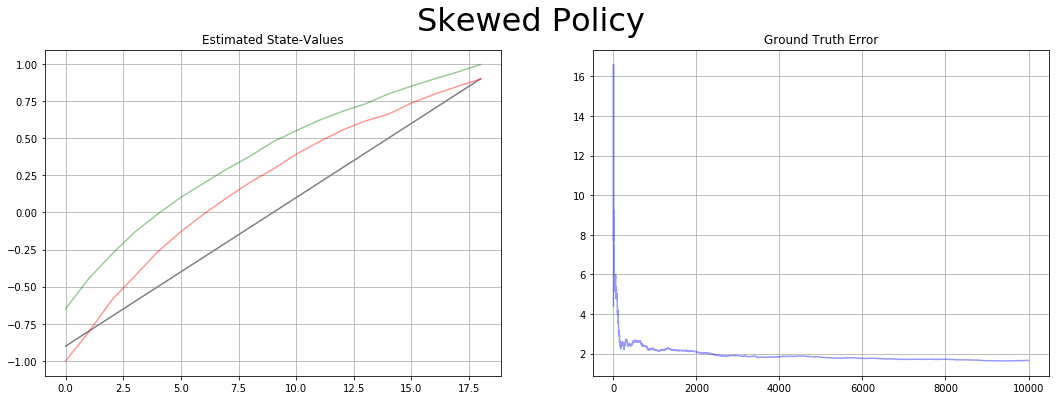

In [8]:
hist = mc_experiment(N=10000, policy=pi_skewed)
plot_experiments('Skewed Policy', [hist])

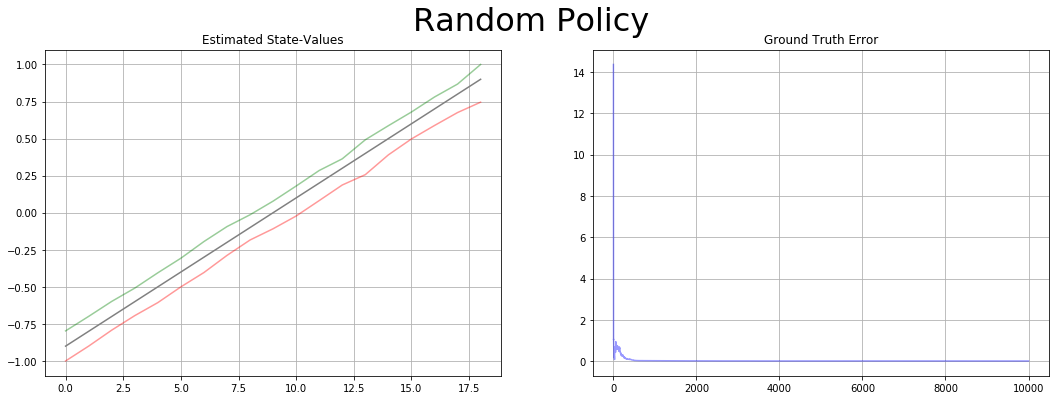

In [9]:
hist = mc_experiment(N=10000, policy=pi_random)
plot_experiments('Random Policy', [hist])

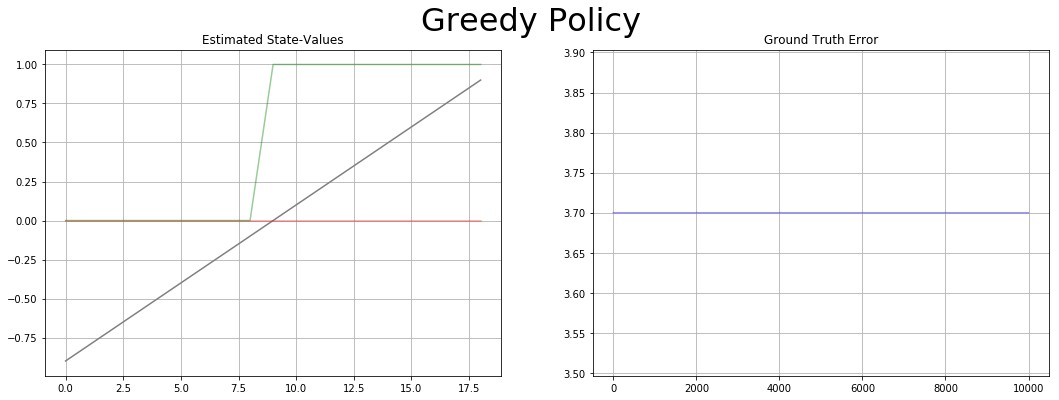

In [10]:
hist = mc_experiment(N=10000, policy=pi_greedy)
plot_experiments('Greedy Policy', [hist])

# TD(0) - On Policy

In [11]:
def td0_experiment(N, alpha, policy):
    hist = []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = Rt_1 + 1.0*Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        hist.append(Q.copy())
    return np.array(hist)

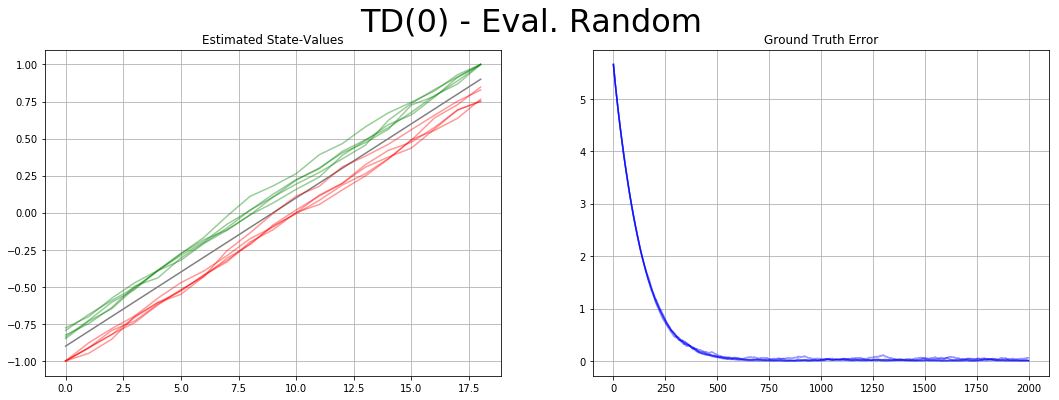

In [12]:
histories = []
for _ in range(5):
    hist = td0_experiment(N=2000, alpha=0.05, policy=pi_random)
    histories.append(hist)
plot_experiments('TD(0) - Eval. Random', histories)

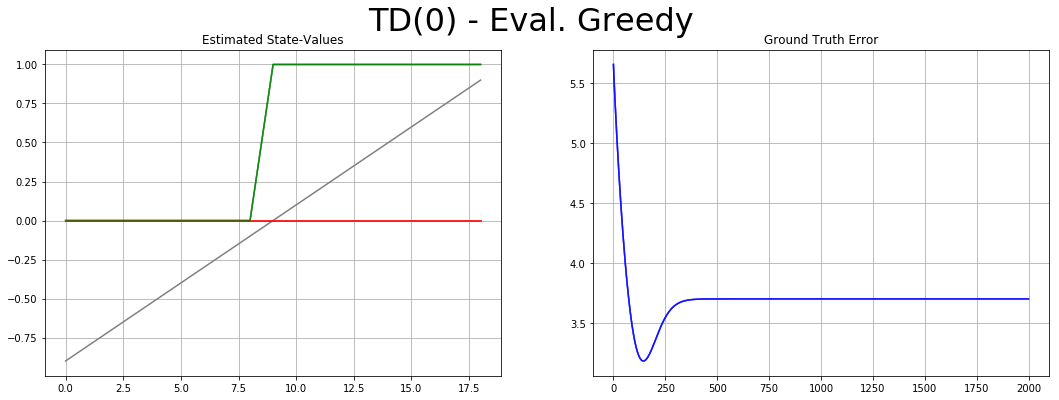

In [13]:
histories = []
for _ in range(5):
    hist = td0_experiment(N=2000, alpha=0.05, policy=pi_greedy)
    histories.append(hist)
plot_experiments('TD(0) - Eval. Greedy', histories)

# TD(0) - with Expected Return

In [14]:
def exp_td0_experiment(N, alpha, pol_beh, pol_tar):
    hist = []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(pol_beh)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            # target = Q[St_1, At_1]  # sarsa
            target = pol_tar[St, 0]*Q[St_1, 0] + pol_tar[St, 1]*Q[St_1, 1]  # exp sarsa
            Q[St, At] = Q[St, At] + alpha * (Rt_1 + 1.0*target - Q[St, At])
        hist.append(Q.copy())
    return np.array(hist)

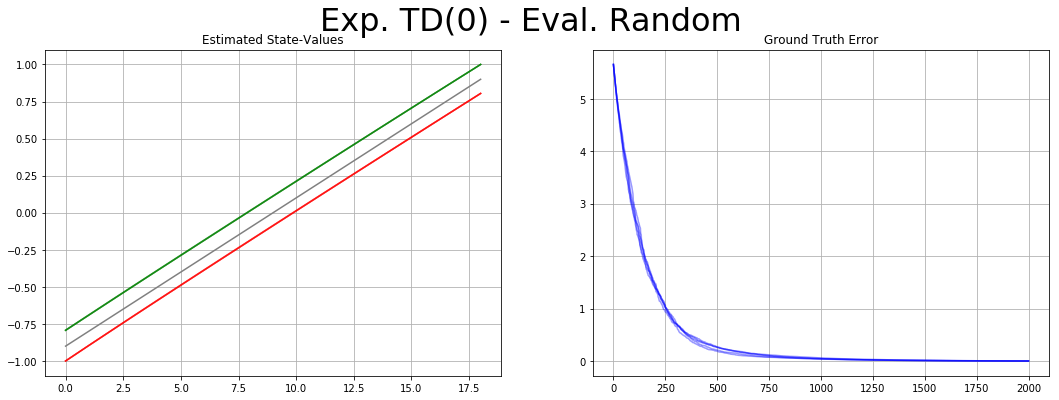

In [15]:
histories = []
for _ in range(5):
    hist = exp_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_random)
    histories.append(hist)
plot_experiments('Exp. TD(0) - Eval. Random', histories)

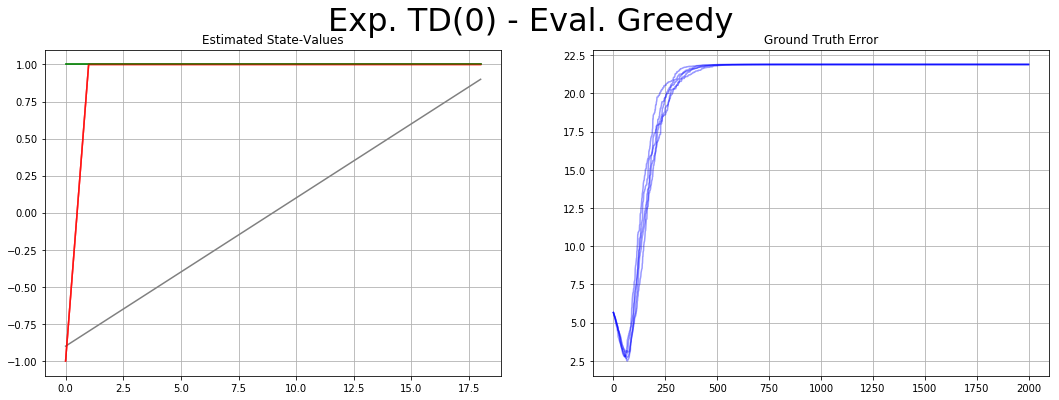

In [16]:
histories = []
for _ in range(5):
    hist = exp_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_greedy)
    histories.append(hist)
plot_experiments('Exp. TD(0) - Eval. Greedy', histories)

# TD(0) with Importance Sampling

In [17]:
def is_td0_experiment(N, alpha, pol_beh, pol_tar):
    hist = []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(pol_beh)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = (pol_tar[St, At] / pol_beh[St, At]) * Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (Rt_1 + 1.0*target - Q[St, At])
        hist.append(Q.copy())
    return np.array(hist)

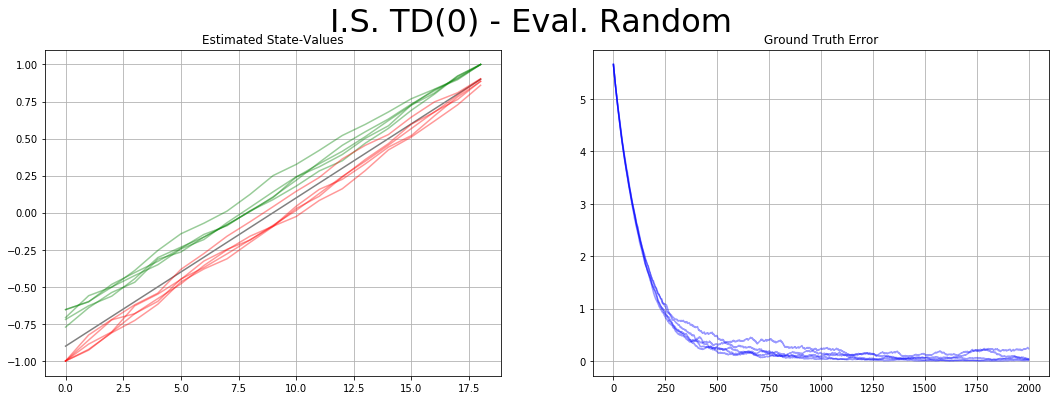

In [18]:
histories = []
for _ in range(5):
    hist = is_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_random)
    histories.append(hist)
plot_experiments('I.S. TD(0) - Eval. Random', histories)

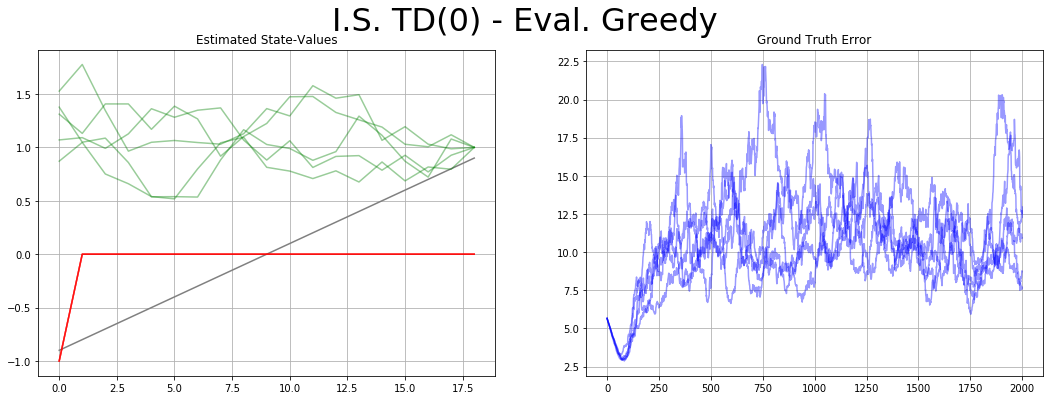

In [19]:
histories = []
for _ in range(5):
    hist = is_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_greedy)
    histories.append(hist)
plot_experiments('I.S. TD(0) - Eval. Greedy', histories)